# Multi-network simulation test

## Simulate multiple networks with each set of parameters

### Parameters to vary:

* Number of regions
* **SNR**
    * Correlated vs. independent noise? Stick to independent for now since it's easier to generate
* IV probability
* **IV gain**
* Max eigenvalue i.e. spectral radius
    * Update - this is actually linked to the SNR, can't be controlled independently
* Heterogeneity between regions?

## Test ability of "real" vs. "pseudo" IV analysis to recover the actual connectivity strengths

### Measures of success:

* Correlation
    * Pearson vs. Spearman (rank)?
    * Compare overlap of distributions/confidence intervals?

In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
import network_sim as netsim
import iv_analysis as iv
from iv_analysis import methods
import os.path
import matplotlib.pyplot as plt
import contextlib

### Create parameter set

In [2]:
n_regions = 10
n_trials = 200
n_time = 1000

iv_prob = 0.025

gains = np.arange(0.05, 1.05, 0.05)
snrs = np.logspace(-1, 1, 9)
steps_per_time = [1, 10]

### Do trials for each set of parameters

In [3]:
def seeded_sim_network(gain, snr, steps_per_time, seed: np.uint32=None):
    """Simulate network with specific rng seed and parameters"""
    
    if seed is not None:
        assert np.isscalar(seed), 'Seed must be a scalar'
        np.random.seed(seed)

    con_mat = netsim.gen_con_mat(n_regions, net_type='smallworld')
    return netsim.sim_network(
        con_mat=con_mat,
        n_time=n_time,
        iv_prob=iv_prob,
        iv_gain=gain,
        snr=snr,
        steps_per_time=steps_per_time
    )

result_file = '../data_sim/iv_rs_w_seed.npz'

if not os.path.exists(result_file):
    result_shape = (len(gains), len(snrs), len(steps_per_time), n_trials)
    
    beta_rs = {method: np.ndarray(result_shape) for method in methods}
    seeds = np.random.randint(0, 2 ** 32, dtype=np.uint32, size=result_shape)

    for i, gain in enumerate(gains):
        for j, snr in enumerate(snrs):
            for k, spt in enumerate(steps_per_time):
                for l in range(n_trials):
                    
                    # generate network and simulate
                    log_act, ivs, scaled_mat = seeded_sim_network(gain, snr, spt, seeds[i, j, k, l])

                    # do analyses
                    for key, method in methods.items():
                        betas = method['fn'](log_act, ivs)

                        # correlate with actual connectivity
                        beta_rs[key][i, j, k, l], _ = stats.pearsonr(betas.flatten(), scaled_mat.flatten())

    np.savez(result_file, seeds=seeds, **beta_rs)

## Load results and plot

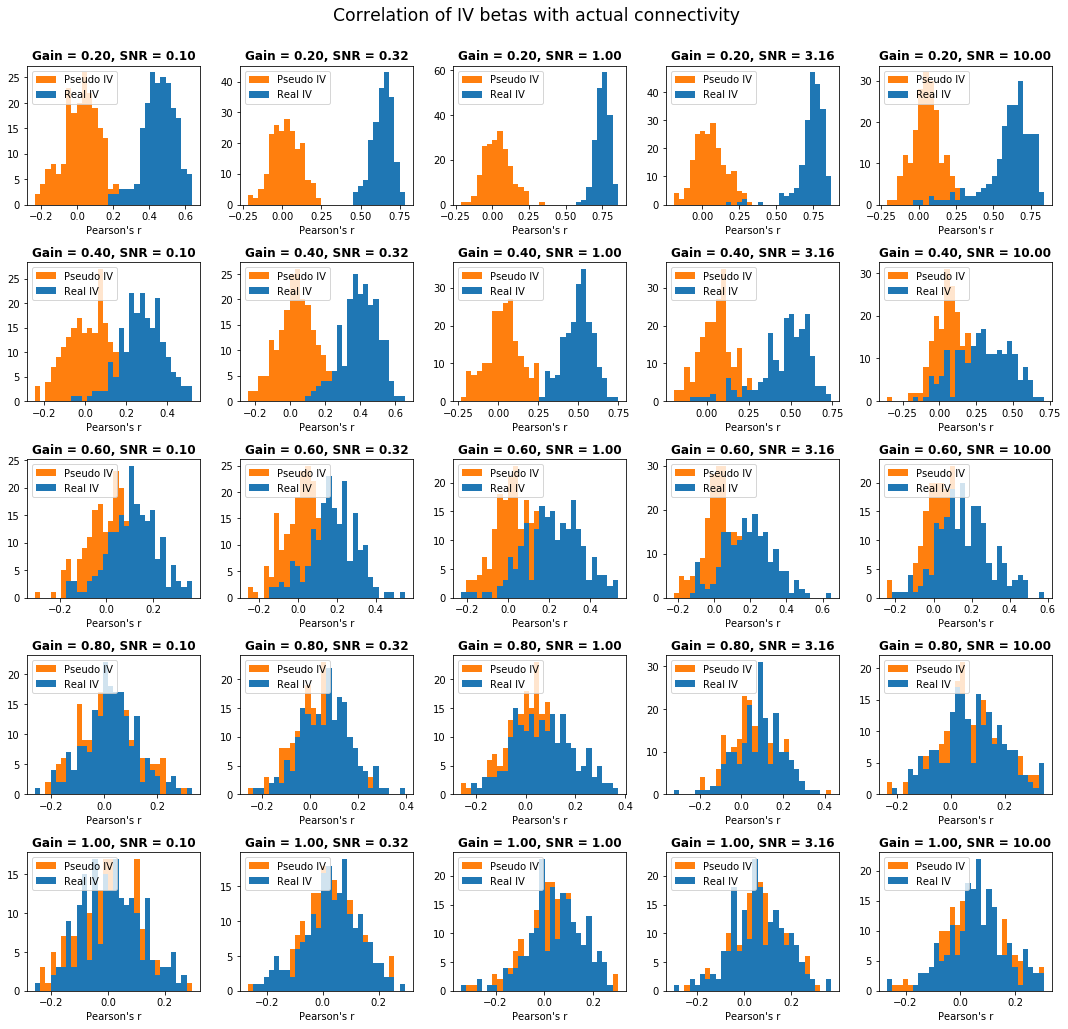

In [4]:
# example histograms, compare with gain = 0.1 and  snr = 10:

def compare_correlations(ax, gain_i, snr_i, steps_i, open_file=None):
    with contextlib.nullcontext(open_file) if open_file else np.load(result_file) as iv_rs:

        ax.hist([
            iv_rs['real'][gain_i, snr_i, steps_i, :].flatten(),
            iv_rs['pseudo'][gain_i, snr_i, steps_i, :].flatten()],
            label=['Real IV', 'Pseudo IV'],
            histtype='stepfilled',
            bins=30
        )

        ax.set_xlabel('Pearson\'s r')
        ax.legend(loc='upper left')
        ax.set_title('Gain = {:.2f}, SNR = {:.2f}'.format(gains[gain_i], snrs[snr_i]), weight='bold')

gain_inds_to_plot = np.arange(3, len(gains), 4)
snr_inds_to_plot = np.arange(0, len(snrs), 2)

fig, axes = plt.subplots(len(gain_inds_to_plot), len(snr_inds_to_plot), figsize=(15, 15))

fig.suptitle('Correlation of IV betas with actual connectivity', size='xx-large')

with np.load(result_file) as open_file:
    for i, gain_i in enumerate(gain_inds_to_plot):
        for j, snr_i in enumerate(snr_inds_to_plot):
            compare_correlations(axes[i, j], gain_i, snr_i, 0, open_file)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.draw()

In [5]:
# example scatterplots
# generate one network of each type and plot actual connectivity vs. iv betas vs. correlations

con_mats = np.ndarray((len(gains), len(snrs), n_regions, n_regions))

betas = {method: con_mats.copy() for method in methods}
beta_rs = {method: np.ndarray((len(gains), len(snrs))) for method in methods}

failed_once = False
for i, gain in enumerate(gains):
    for j, snr in enumerate(snrs):
        
        # generate network and simulate       
        if not failed_once:  # work around matplotlib bug
            try:
                log_act, ivs, con_mats[i, j] = seeded_sim_network(gain, snr, 1)
            except np.linalg.LinAlgError:
                failed_once = True
                
        if failed_once:
            log_act, ivs, con_mats[i, j] = seeded_sim_network(gain, snr, 1)

        # do iv analyses
        for key, method in methods.items():
            est = method['fn'](log_act, ivs)
            betas[key][i, j] = est
            
            beta_rs[key][i, j], _ = stats.pearsonr(est.flatten(), con_mats[i, j].flatten())

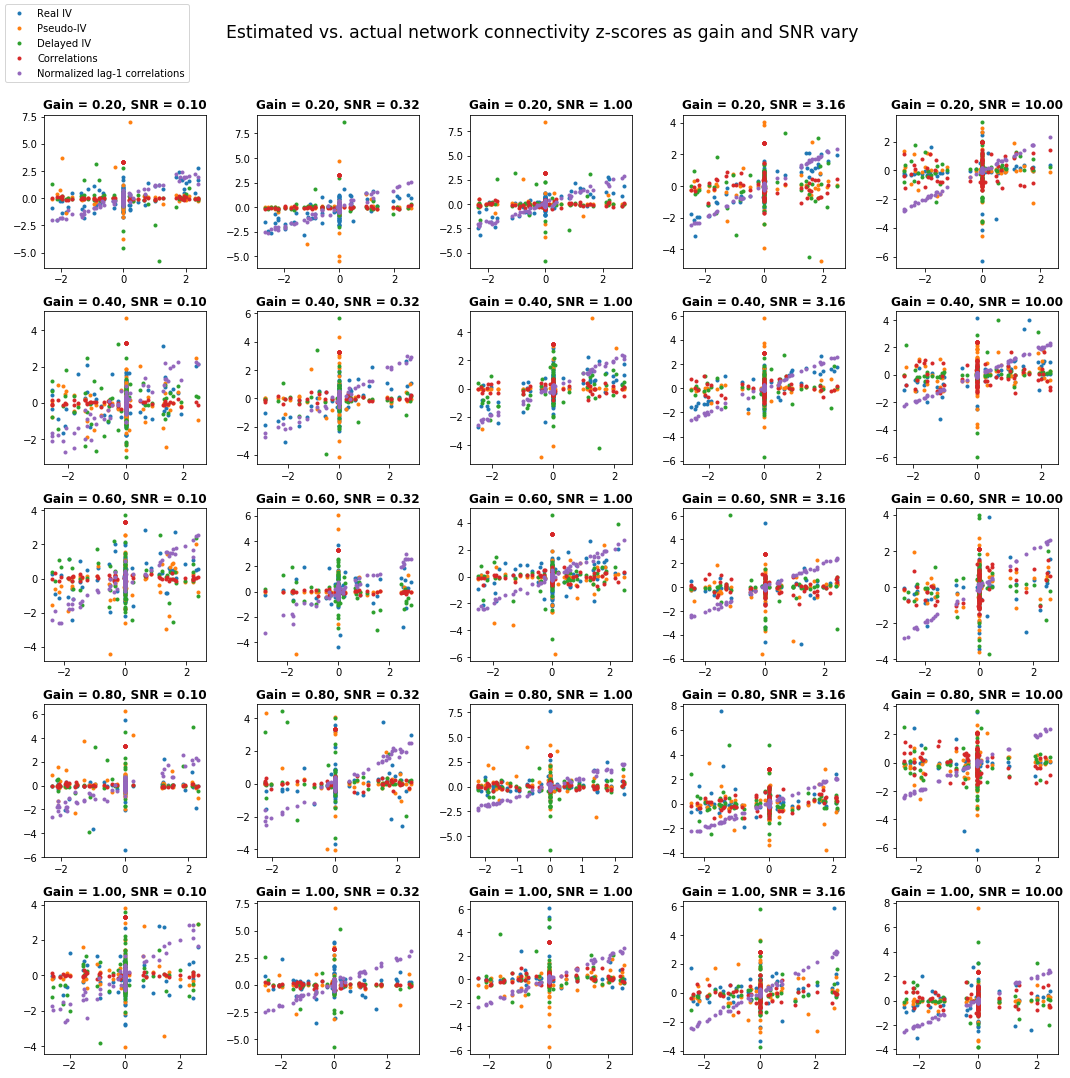

In [6]:
def scatter_all_methods(con_mats, est_mats, gain_inds=gain_inds_to_plot, snr_inds=snr_inds_to_plot):
    """
    Plot sample connectivity estimates against actually connectivity, for a range of gains and SNRs.
    
    :param con_mats: connectivity matrices, array of shape (len(gain_inds), len(snr_inds), n_regions, n_regions)
    :param est_mats: dict mapping method keys to estimate matrices; each entry has same shape as con_mats
    :param gain_inds: indices into `gains` to plot
    :param snr_inds: indices into `snrs` to plot
    """

    fig, axes = plt.subplots(len(gain_inds), len(snr_inds), figsize=(15, 15))

    fig.suptitle('Estimated vs. actual network connectivity z-scores as gain and SNR vary',
                size='xx-large')

    for i, gain_i in enumerate(gain_inds):
        for j, snr_i in enumerate(snr_inds):

            ax = axes[i, j]
            this_normed_mat = lambda mat_mat: mat_mat[gain_i, snr_i] / np.std(mat_mat[gain_i, snr_i]) 

            norm_con_mat = this_normed_mat(con_mats)

            for key, method in methods.items():
                norm_ests = this_normed_mat(est_mats[key])        
                ax.plot(norm_con_mat.flatten(), norm_ests.flatten(), '.', label=method['name'])

            ax.set_title('Gain = {:.2f}, SNR = {:.2f}'.format(gains[gain_i], snrs[snr_i]), weight='bold')

    handles, labels = axes[-1, -1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')

    fig.tight_layout(rect=[0, 0, 1, 0.92])    
    return fig
    
scatter_all_methods(con_mats, betas)
plt.draw()

### Compare correctness of pseudo and real IV betas

In [7]:
def calc_dist_matrix(multidim_data, norm_ord=2):
    """
    Find the pairwise distances between multidimensional points.
    Input multidim_data should be N x D
    Distance is defined by an L2 norm by default, or specify norm_ord parameter as in np.norm
    """
    
    # rotate so variables are in 3rd dimension
    data1 = np.transpose(multidim_data[:, :, np.newaxis], (0, 2, 1))
    data2 = np.transpose(multidim_data[:, :, np.newaxis], (2, 0, 1))
    
    diff = data1 - data2  # now N x N x D
    return np.linalg.norm(diff, ord=norm_ord, axis=2)

# test on a partial cube
print(calc_dist_matrix(np.array([
    [0., 0., 0.],
    [0., 1., 0.],
    [0., 1., 1.],
    [1., 1., 1.]
])))

[[0.         1.         1.41421356 1.73205081]
 [1.         0.         1.         1.41421356]
 [1.41421356 1.         0.         1.        ]
 [1.73205081 1.41421356 1.         0.        ]]


In [8]:
def get_medoid_ind(multidim_data, norm_ord=2):
    """
    Return the index of the mediod of multidim_data, which is the point with minimal total
    distance to all other points, as defined by the norm of choice.
    """
    
    dist = calc_dist_matrix(multidim_data, norm_ord=norm_ord)
    return np.argmin(np.sum(dist, axis=0))

octo = np.array([
    [1., 0., 0.],
    [0., 1., 0.],
    [0., 0., 1.],
    [-1., 0., 0.],
    [0., -1., 0.],
    [0., 0., -1.],
    [0., 0., 0.],
])

np.set_printoptions(precision=3)
print('Dist matrix:')
print(calc_dist_matrix(octo))
print('Medoid index:', get_medoid_ind(octo))

Dist matrix:
[[0.    1.414 1.414 2.    1.414 1.414 1.   ]
 [1.414 0.    1.414 1.414 2.    1.414 1.   ]
 [1.414 1.414 0.    1.414 1.414 2.    1.   ]
 [2.    1.414 1.414 0.    1.414 1.414 1.   ]
 [1.414 2.    1.414 1.414 0.    1.414 1.   ]
 [1.414 1.414 2.    1.414 1.414 0.    1.   ]
 [1.    1.    1.    1.    1.    1.    0.   ]]
Medoid index: 6


In [9]:
# Get indices of medoid runs, given all methods
medoid_inds = np.ndarray((len(gains), len(snrs), len(steps_per_time)), dtype=int)

with np.load(result_file) as iv_rs:
    for i in range(len(gains)):
        for j in range(len(snrs)):
            for k in range(len(steps_per_time)):

                all_rs = np.ndarray((n_trials, len(methods)))
                for m, method in enumerate(methods):
                    all_rs[:, m] = iv_rs[method][i, j, k, :]

                medoid_inds[i, j, k] = get_medoid_ind(all_rs)

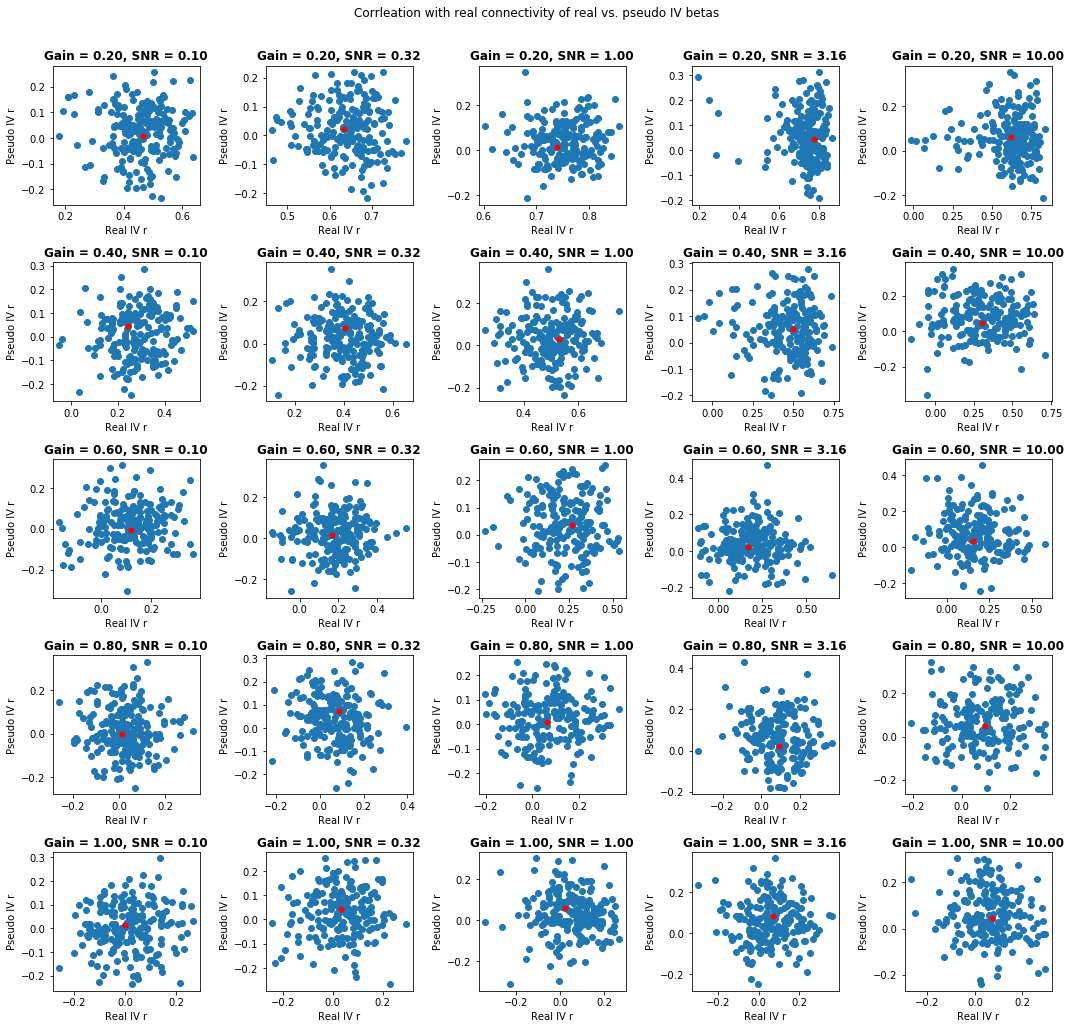

In [10]:
fig, axes = plt.subplots(len(gain_inds_to_plot), len(snr_inds_to_plot), figsize=(15, 15))

fig.suptitle('Corrleation with real connectivity of real vs. pseudo IV betas')

def scatter_real_pseudo_r(ax, gain_i, snr_i, steps_i, open_file=None):
    with contextlib.nullcontext(open_file) if open_file else np.load(result_file) as iv_rs:
        
        real_rs = iv_rs['real'][gain_i, snr_i, steps_i, :]
        pseudo_rs = iv_rs['pseudo'][gain_i, snr_i, steps_i, :]
        
        ax.plot(real_rs, pseudo_rs, 'o')
        
        mind = medoid_inds[gain_i, snr_i, steps_i]
        ax.plot(real_rs[mind], pseudo_rs[mind], 'ro', markersize=5)
        
        ax.set_xlabel('Real IV r')
        ax.set_ylabel('Pseudo IV r')
        ax.set_title('Gain = {:.2f}, SNR = {:.2f}'.format(gains[gain_i], snrs[snr_i]), weight='bold')

with np.load(result_file) as open_file:
    for i, gain_i in enumerate(gain_inds_to_plot):
        for j, snr_i in enumerate(snr_inds_to_plot):
            scatter_real_pseudo_r(axes[i, j], gain_i, snr_i, 0, open_file)
            
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.draw()

In [11]:
# re-simulate networks corresponding to medoids and make scatterplots

def scatter_all_methods_medoid(steps_i, exp_con_mat=False, *args, **kwargs):    
    with np.load(result_file) as iv_rs:
        con_mats = np.ndarray((len(gains), len(snrs), n_regions, n_regions))
        est_mats = {method: con_mats.copy() for method in methods}
        
        spt = steps_per_time[steps_i]
        
        for i, gain in enumerate(gains):
            for j, snr in enumerate(snrs):

                # re-seed and simulate network
                seed = iv_rs['seeds'][i, j, steps_i, medoid_inds[i, j, steps_i]]

                log_act, ivs, con_mats[i, j] = seeded_sim_network(gain, snr, spt, seed)
                
                if exp_con_mat:
                    con_mats[i, j] = np.linalg.matrix_power(con_mats[i, j], spt)

                # estimate connectivity
                for key, method in methods.items():
                    est_mats[key][i, j] = method['fn'](log_act, ivs)
        
    fig = scatter_all_methods(con_mats, est_mats, *args, **kwargs)
    fig.suptitle('Estimated vs. actual connectivity z-scores for median-difficulty networks')
    return fig

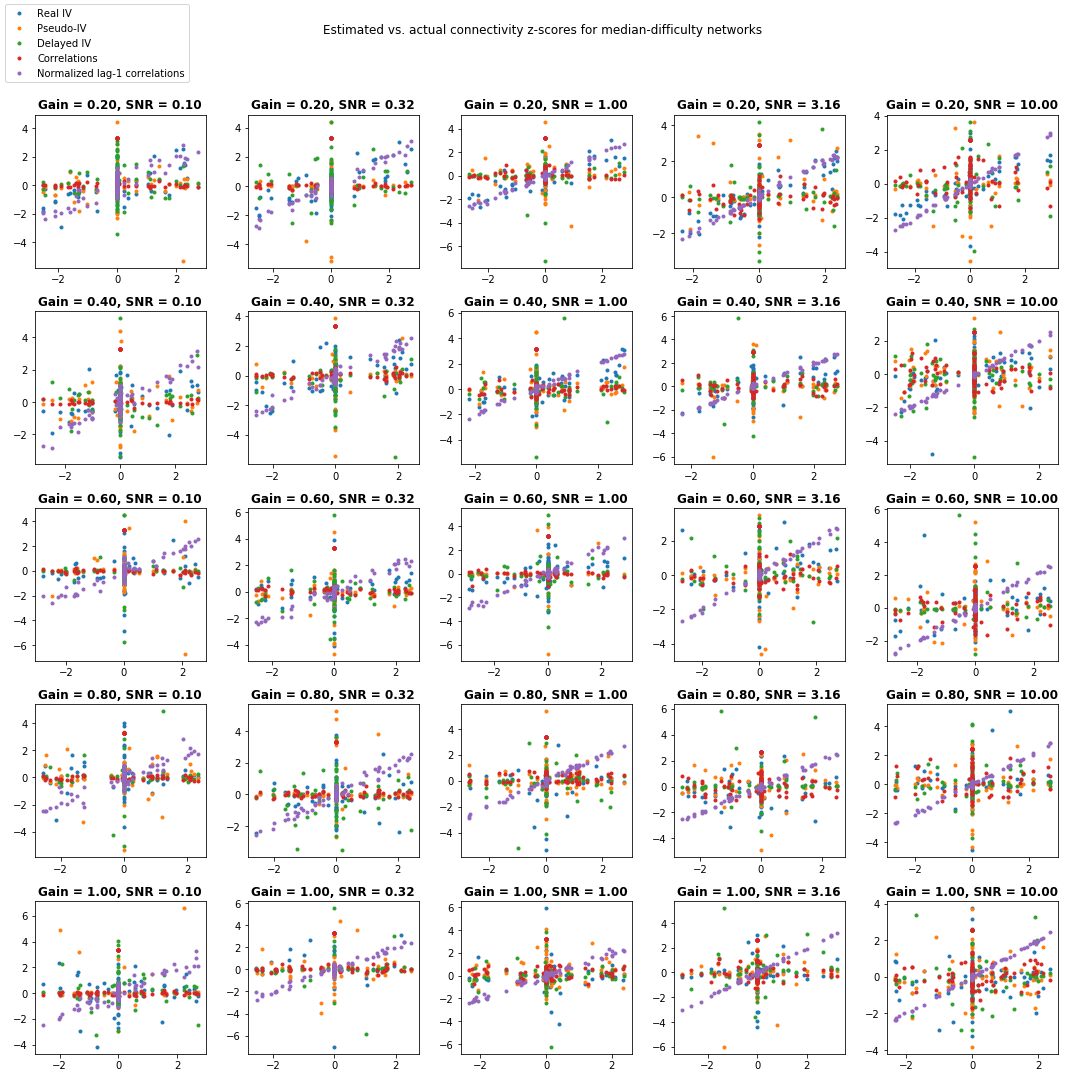

In [12]:
scatter_all_methods_medoid(0)
plt.draw()

### For each connectivity measure (real IV, delayed IV, pseudo-IV, and correlation), plot a heatmap of the median correlation with the actual connectivity.

In [13]:
def corr_heatmap(steps_i, exp_con_mat=False):

    fig = plt.figure(figsize=(15, 30))

    with np.load(result_file) as iv_rs:
        for m, (key, method) in enumerate(methods.items()):

            if exp_con_mat:
                spt = steps_per_time[steps_i]
                med_rs = np.ndarray((len(gains), len(snrs)))
                
                # re-simulate medoid networks
                for i, gain in enumerate(gains):
                    for j, snr in enumerate(snrs):
                        
                        seed = iv_rs['seeds'][i, j, steps_i, medoid_inds[i, j, steps_i]]
#                         try:
                        log_act, ivs, con_mat = seeded_sim_network(gain, snr, spt, seed)
#                         except np.linalg.LinAlgError:
#                             print('Gain:', gain)
#                             print('SNR:', snr)
#                             print('SPT:', spt)
#                             print('seed:', seed)
#                             raise
                            
                        betas = method['fn'](log_act, ivs)
                        
                        exp_mat = np.linalg.matrix_power(con_mat, spt)
                        med_rs[i, j], _ = stats.pearsonr(betas.flatten(), exp_mat.flatten())
                        
            else:                
                med_rs = np.median(iv_rs[key][-1::-1, :, steps_i, :], axis=2)
             
            ax = fig.add_subplot(3, 2, m + 1)

            im = ax.imshow(med_rs, origin='lower', vmin=0.0, vmax=1.0)
            plt.colorbar(im, ax=ax)

            name = method['name'][0].lower() + method['name'][1:]
            ax.set_title(f'Pearson\'s r of {name} between regions with actual connectivities')

            # fix ticks
            ax.set_xticks([-0.5] + list(range(len(snrs))) + [len(snrs) - 0.5])
            ax.set_yticks([-0.5] + list(range(len(gains))) + [len(gains) - 0.5])

            ax.set_xticklabels([''] + ['{:.2f}'.format(snr) for snr in snrs])
            ax.set_yticklabels(reversed(['{:.2f}'.format(1.0 - gain) for gain in gains] + ['']))      

            ax.set_ylabel('Fraction attenuated in IV event (0.0 = no effect)')
            ax.set_xlabel('SNR of network (recurrent inputs vs. external noise)')

    fig.tight_layout()
    return fig

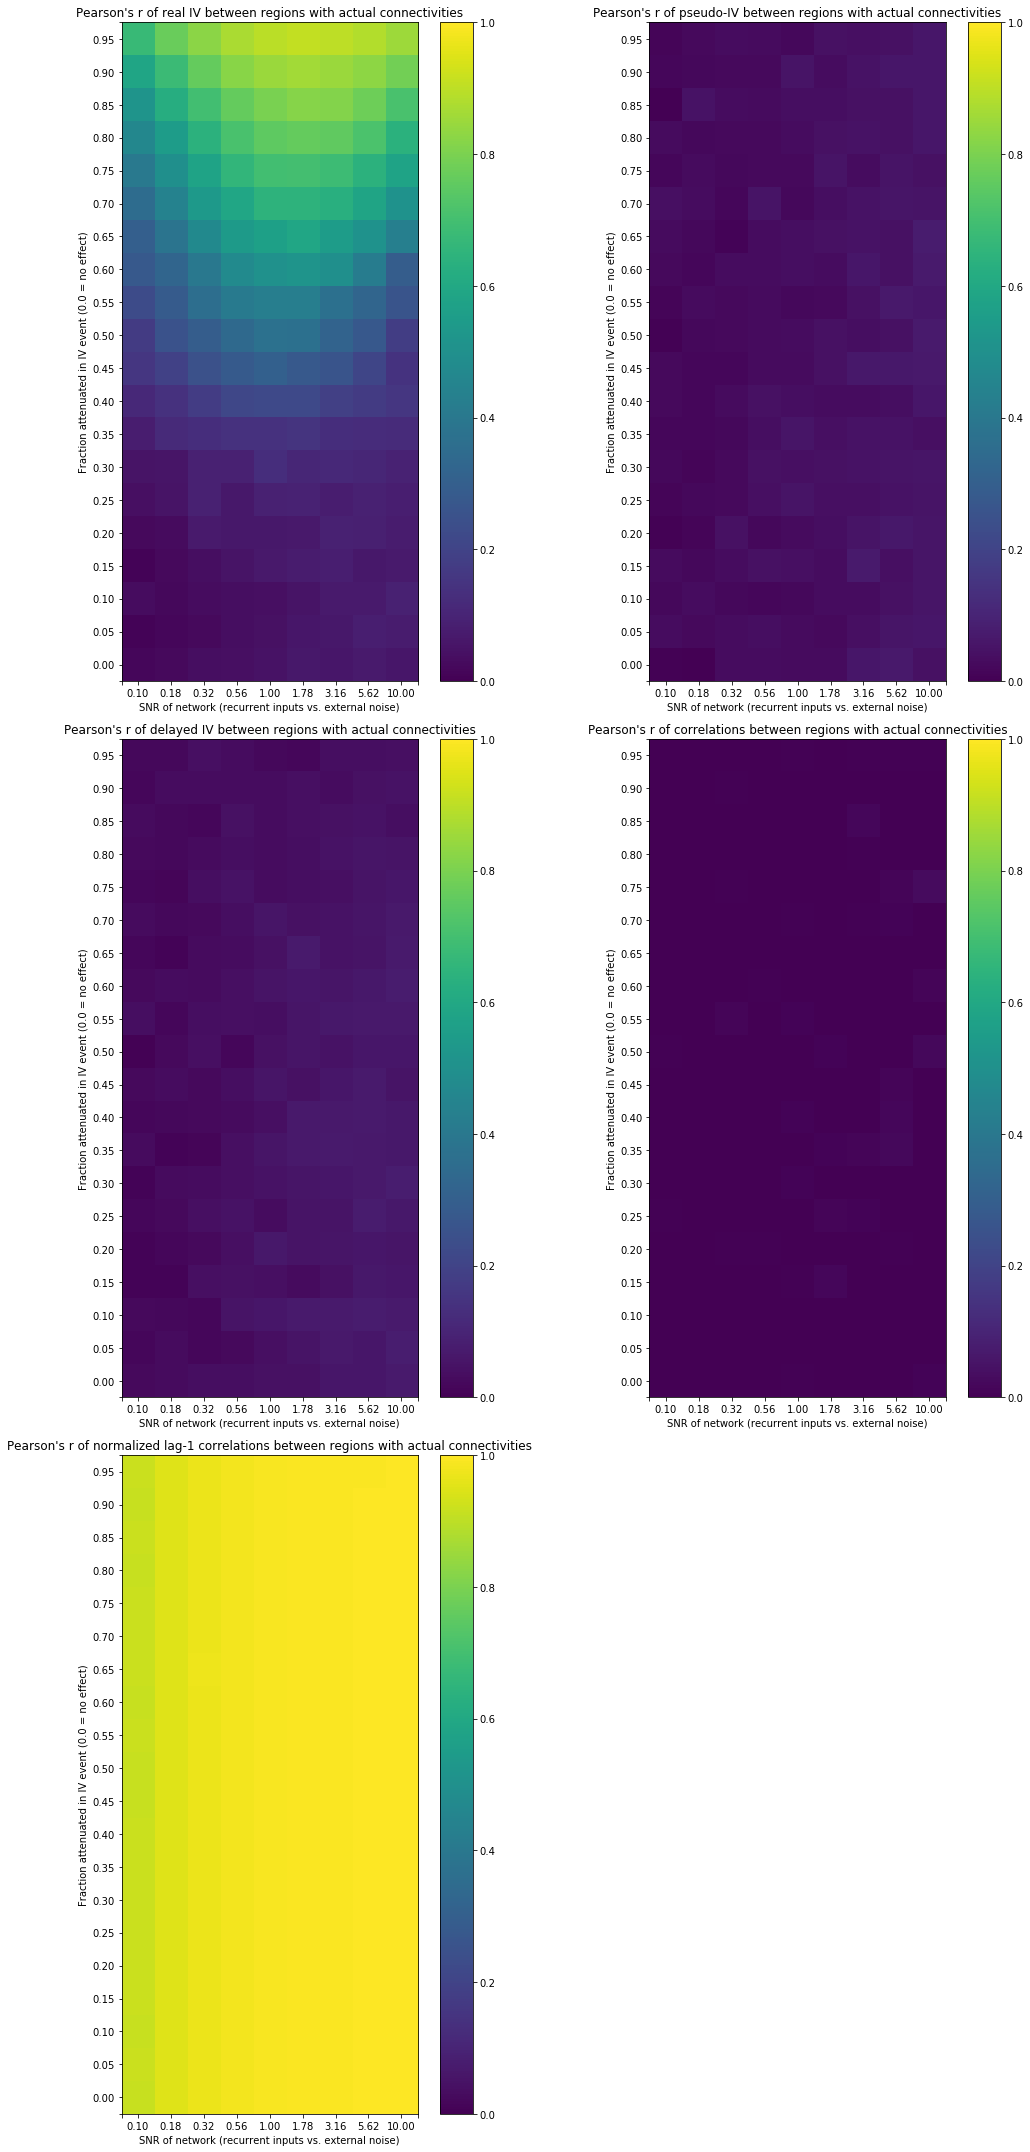

In [14]:
corr_heatmap(0)
plt.draw()

### Repeat analyses with 10 steps per time

In [15]:
scatter_all_methods_medoid(1)
plt.draw()

LinAlgError: Eigenvalues did not converge

In [ ]:
corr_heatmap(1)
plt.draw()

### Try using exponentiated transition matrix as ground truth (getting less causal)

In [ ]:
scatter_all_methods_medoid(1, exp_con_mat=True)
plt.draw()

In [ ]:
corr_heatmap(1, exp_con_mat=True)
plt.draw()